In [1]:
from invisible_cities.io.dst_io import load_dst, load_dsts, df_writer
from glob import glob
import numpy as np
import pandas as pd
import tables as tb
import re
import matplotlib.pyplot as plt

from krcal.core.selection_functions import selection_in_band
from krcal. core.correction_functions import e0_xy_correction
from invisible_cities.reco.corrections     import read_maps                                                                      
from invisible_cities.reco.corrections     import norm_strategy 
from scipy.optimize import curve_fit

from datetime import timedelta

# Dorothea was run on ~150 kr runs using https://github.com/mmkekic/IC/tree/modified_dsts_tables branch that outputs dorothea and penthesilea tables per pmt

# select_and_group_dorotheas.py

The script contains of 3 parts:
1. select kr events using ICAROS selection_in_band function
2. using only events from inner core (fixed to 70mm) calculates E0 and lt using curve fit
3. divides run into xy bins tables (20x20 mm bins)

### step 1, 2 example

In [2]:
import sys
sys.path.append("/home/mmkekic/energy_resolution_study/data_S2_LightTable/select_and_group_dorotheas.py")
import  select_and_group_dorotheas as chunk_utils

In [5]:
dorothea_f = "/home/mmkekic/energy_resolution_study/kr_data/data_runs_dorotheas_per_pmt/kdst_7753.h5"

In [6]:
kdst = chunk_utils.load_and_sel_data(dorothea_f)
kdst.head().T

/home/mmkekic/ICAROS/krcal/core/fit_functions.py:52: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


,0,1,2,3,4
event,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00
s1_peak,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
S1w,1.250000e+02,2.250000e+02,1.750000e+02,2.500000e+02,1.750000e+02
S1h,2.957450e+00,2.838621e+00,1.489477e+00,1.197880e+00,2.574426e+00
S1e,1.162755e+01,1.313246e+01,8.635702e+00,6.640584e+00,1.239404e+01
S1t,4.338500e+05,6.250500e+05,5.314000e+05,4.648250e+05,2.555250e+05
s2_peak,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
S2w,1.232500e+01,9.950000e+00,9.300000e+00,1.032500e+01,1.275000e+01
S2h,2.184160e+03,2.495006e+03,2.264319e+03,2.706115e+03,1.506789e+03
S2e,1.072767e+04,9.670063e+03,1.030788e+04,1.207540e+04,9.169713e+03


In [7]:
#select central part
Rcen = 70 
kdst_cen = kdst[kdst.R<=Rcen]
#use scipy curve_fit to get E0 and LT
# Function e0_lt_fit fits z, E to E0*exp(-Z/LT)


popt, pcov = curve_fit(chunk_utils.e0_lt_fit, kdst_cen.Z, kdst_cen.S2e, p0=[12000, 10000], bounds=((4000, 0), (20000, 100000)))                                                                                                                
lt, e0cen = popt                                                                                                                                                                                                                   
lt_err,e0cen_err = np.sqrt(np.diag(pcov))                                                                                                                                                                                          
                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                       
#add lt and lt_err in dst                                                                                                                                                                                                          
kdst = kdst.assign(lt = lt, lt_err = lt_err, e0cen = e0cen, e0cen_err = e0cen_err)                                                                                                                                                 
cols = [f'E_{x}' for x in range(12)]                                                                                                                                                                                               
kdst = kdst[['event', 'time', 'S2e', 'S2q', 'S2t', 'DT', 'Z', 'X', 'Y', 'R', 'lt', 'lt_err', 'e0cen', 'e0cen_err']+cols]     


Text(0.5, 1.0, 'uncorrected')

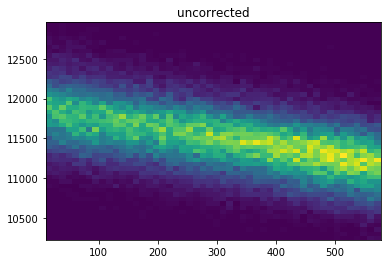

In [8]:
plt.hist2d(kdst_cen.Z, kdst_cen.S2e, bins=50);
plt.title('uncorrected')

Text(0.5, 1.0, 'corrected for LT')

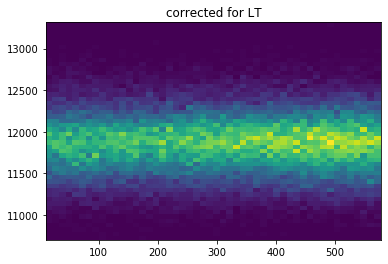

In [9]:
plt.hist2d(kdst_cen.Z, np.exp(kdst_cen.Z/lt)*kdst_cen.S2e, bins=50);
plt.title('corrected for LT')

In [10]:
kdst.head().T #lt and e0 are the same for all events obviously

,0,1,2,3,4
event,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00
time,1.578586e+09,1.578586e+09,1.578586e+09,1.578586e+09,1.578586e+09
S2e,1.072767e+04,9.670063e+03,1.030788e+04,1.207540e+04,9.169713e+03
S2q,6.259160e+02,6.230171e+02,6.148567e+02,6.169346e+02,6.106100e+02
S2t,8.035141e+05,8.024961e+05,8.034816e+05,8.044821e+05,8.034747e+05
DT,3.696641e+02,1.774461e+02,2.720816e+02,3.396571e+02,5.479497e+02
Z,3.696641e+02,1.774461e+02,2.720816e+02,3.396571e+02,5.479497e+02
X,-6.754468e+01,1.320077e+02,4.196706e+01,-4.395747e+01,-3.363612e+01
Y,-1.250827e+02,5.906284e+01,-1.388092e+02,-4.739911e+01,-1.739446e+02
R,1.421547e+02,1.446183e+02,1.450146e+02,6.464469e+01,1.771669e+02


# Examine chunked

In [13]:
chunked_dorothea_f = '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7753.h5'
with tb.open_file(chunked_dorothea_f) as h5in:
    tablenames = h5in.root.KDST.__members__

In [15]:
tablenames # the name is bin_X, binY where bins are range(-200, 200, 20)

['b_9_9',
 'b_9_8',
 'b_9_7',
 'b_9_6',
 'b_9_5',
 'b_9_4',
 'b_9_3',
 'b_9_2',
 'b_9_19',
 'b_9_18',
 'b_9_17',
 'b_9_16',
 'b_9_15',
 'b_9_14',
 'b_9_13',
 'b_9_12',
 'b_9_11',
 'b_9_10',
 'b_9_1',
 'b_9_0',
 'b_8_9',
 'b_8_8',
 'b_8_7',
 'b_8_6',
 'b_8_5',
 'b_8_4',
 'b_8_3',
 'b_8_2',
 'b_8_19',
 'b_8_18',
 'b_8_17',
 'b_8_16',
 'b_8_15',
 'b_8_14',
 'b_8_13',
 'b_8_12',
 'b_8_11',
 'b_8_10',
 'b_8_1',
 'b_8_0',
 'b_7_9',
 'b_7_8',
 'b_7_7',
 'b_7_6',
 'b_7_5',
 'b_7_4',
 'b_7_3',
 'b_7_2',
 'b_7_19',
 'b_7_18',
 'b_7_17',
 'b_7_16',
 'b_7_15',
 'b_7_14',
 'b_7_13',
 'b_7_12',
 'b_7_11',
 'b_7_10',
 'b_7_1',
 'b_7_0',
 'b_6_9',
 'b_6_8',
 'b_6_7',
 'b_6_6',
 'b_6_5',
 'b_6_4',
 'b_6_3',
 'b_6_2',
 'b_6_19',
 'b_6_18',
 'b_6_17',
 'b_6_16',
 'b_6_15',
 'b_6_14',
 'b_6_13',
 'b_6_12',
 'b_6_11',
 'b_6_10',
 'b_6_1',
 'b_6_0',
 'b_5_9',
 'b_5_8',
 'b_5_7',
 'b_5_6',
 'b_5_5',
 'b_5_4',
 'b_5_3',
 'b_5_2',
 'b_5_18',
 'b_5_17',
 'b_5_16',
 'b_5_15',
 'b_5_14',
 'b_5_13',
 'b_5_12',
 'b

In [16]:
chunked_dst = load_dst('/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7753.h5', 'KDST','b_10_12' )

In [26]:
xbins = np.linspace(-200, 200, 21)
xcenters = (xbins[1:]+xbins[:-1])/2
xcenters[10], xcenters[12]

(10.0, 50.0)

In [27]:
chunked_dst.head().T #xbin and ybin are the absolute central values of the bins, ie 10 and 50

,0,1,2,3,4
event,4.640000e+02,8.450000e+02,1.508000e+03,2.475000e+03,2.485000e+03
time,1.578586e+09,1.578586e+09,1.578586e+09,1.578586e+09,1.578586e+09
S2e,1.095805e+04,1.081090e+04,1.120518e+04,1.080586e+04,1.127277e+04
S2q,5.592623e+02,5.186423e+02,5.686646e+02,5.047864e+02,5.490198e+02
S2t,8.044938e+05,8.044932e+05,8.044913e+05,8.024971e+05,8.025222e+05
DT,5.068438e+02,4.284683e+02,5.151163e+02,4.532971e+02,1.717222e+02
Z,5.068438e+02,4.284683e+02,5.151163e+02,4.532971e+02,1.717222e+02
X,4.422262e+00,1.510191e+01,7.278312e+00,1.840904e+01,9.207348e+00
Y,5.535105e+01,4.727729e+01,5.047328e+01,5.642542e+01,4.766758e+01
R,5.552743e+01,4.963074e+01,5.099535e+01,5.935251e+01,4.854868e+01


## Lets examine lifetime evolution

In [28]:
#load all lifetimes
folder_out = '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/'

files = glob(folder_out+'*.h5')

In [29]:
files

['/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7753.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7755.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7757.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7758.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7759.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7761.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7762.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7763.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7764.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7765.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/chunked_dorotheas/kdst_chunked_7766.h5',
 '/home/mmkekic/energ

In [30]:
lts = []
lts_err = []
time = []
for f in files:
    with tb.open_file(f) as tab:
        row = tab.root.KDST.b_10_10.read(0, 1)
        lts.extend(row['lt'])
        lts_err.extend(row['lt_err'])
        time.extend(row['time'])

In [31]:
days = list(map(lambda x:timedelta(seconds=x).days, time))

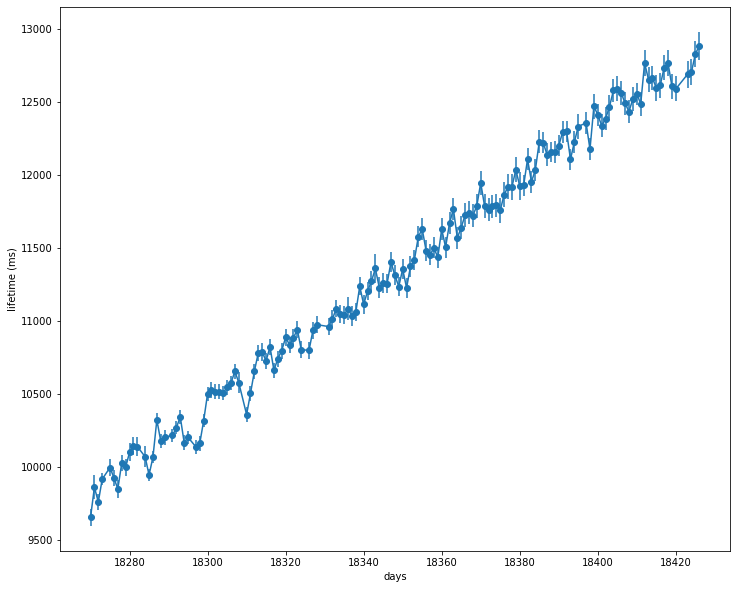

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.errorbar(days, lts, yerr=lts_err, marker='o')
plt.ylabel('lifetime (ms)')
plt.xlabel('days')
plt.show()

### LT makes sense, save for future if needed

In [33]:
df = pd.DataFrame({'days':days, 'lt':lts, 'lt_err':lts_err})

In [61]:
#df.to_csv(folder_out+'/lifetime_summary.csv')

# create_lts.py

I assume uniform lifetime across whole detector, the one calculated using the inner core.
In that case we only need to correct all events per unique lifetime and simply find mean value of corrected energies that fall within each bin (in the script bin size was fixed to 1mm)
The script calculated moving averages as well as a complete map

In [39]:
folder = '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/'
files = glob(folder+'*.h5')

In [40]:
files

['/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7753_7837.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7753_8056.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7761_7842.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7766_7866.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7775_7872.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7814_7881.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7827_7913.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7838_7919.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7849_7924.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7867_7935.h5',
 '/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7877_7940.h5',

## load one file (a full map one for example)

In [60]:
lt_7753_8056 = load_dst("/home/mmkekic/energy_resolution_study/kr_data/moving_runs_average_lt/runs_7753_8056.h5", 'LT', 'LightTable')

In [61]:
lt_7753_8056.head()

,xbin,ybin,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,...,stde_5,stde_6,stde_7,stde_8,stde_9,stde_10,stde_11,e_tot,stde_tot,nevents
0,-19.5,-19.5,0.094406,0.119418,0.094855,0.061656,0.100651,0.081245,0.072900,0.073044,...,0.003112,0.003025,0.002891,0.003233,0.003024,0.003141,0.002902,1.012481,0.017133,895.0
1,-19.5,-18.5,0.094367,0.119071,0.094927,0.061616,0.100668,0.081096,0.072793,0.072970,...,0.003145,0.003030,0.002844,0.003224,0.002860,0.003210,0.002895,1.010974,0.018151,910.0
2,-19.5,-17.5,0.094446,0.119032,0.094729,0.061592,0.100485,0.081203,0.072724,0.072966,...,0.003064,0.003038,0.003005,0.003246,0.002845,0.003158,0.002959,1.010425,0.017636,887.0
3,-19.5,-16.5,0.094202,0.118997,0.094733,0.061315,0.100580,0.081128,0.072682,0.072874,...,0.003025,0.003014,0.002988,0.003391,0.002975,0.003215,0.002814,1.009676,0.017821,907.0
4,-19.5,-15.5,0.094308,0.118824,0.094615,0.061530,0.100397,0.080921,0.072649,0.072920,...,0.003172,0.002896,0.003008,0.003274,0.002971,0.003234,0.002863,1.009725,0.018082,897.0


In [62]:
e0s = pd.pivot_table(lt_7753_7837[['xbin', 'ybin','e_tot']], index = 'xbin', columns='ybin')
es = [pd.pivot_table(lt_7753_7837[['xbin', 'ybin',f'e_{i}']], index = 'xbin', columns='ybin') for i in range(12)]

std0s = pd.pivot_table(lt_7753_7837[['xbin', 'ybin','stde_tot']], index = 'xbin', columns='ybin')
stdes = [pd.pivot_table(lt_7753_7837[['xbin', 'ybin',f'stde_{i}']], index = 'xbin', columns='ybin') for i in range(12)]
nevs = pd.pivot_table(lt_7753_7837[['xbin', 'ybin','nevents']], index = 'xbin', columns='ybin')


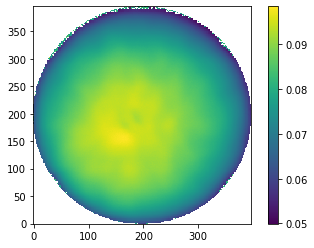

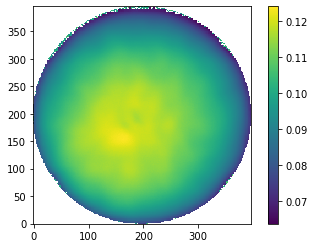

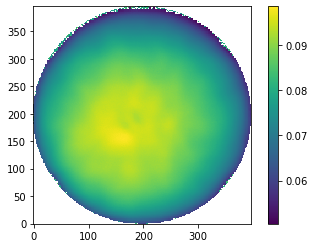

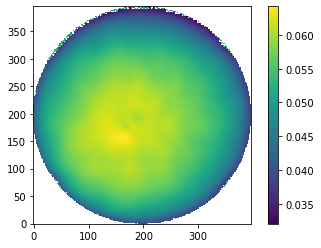

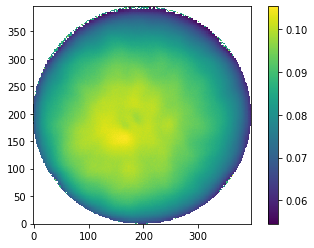

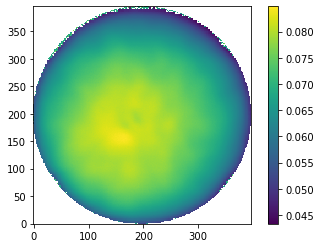

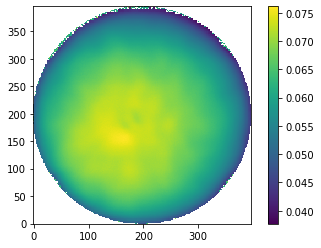

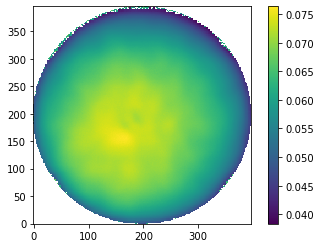

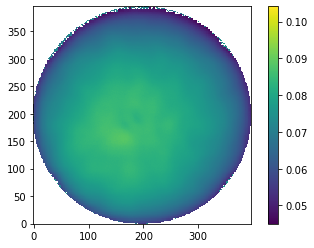

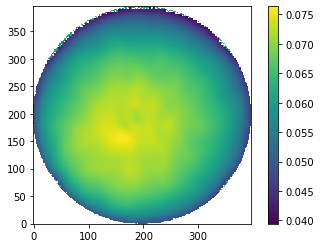

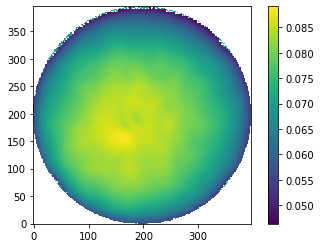

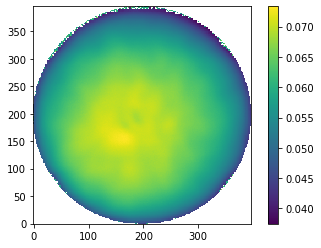

In [63]:
for i in range(12):
    plt.imshow(es[i].T, origin='lower')
    plt.colorbar()
    plt.show()

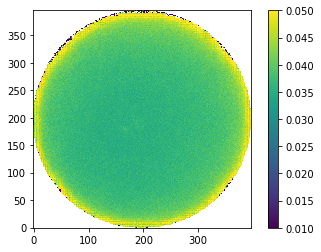

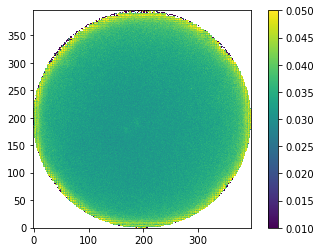

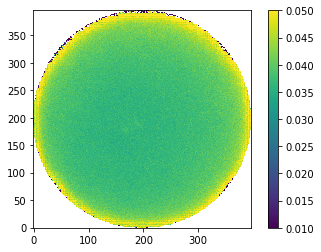

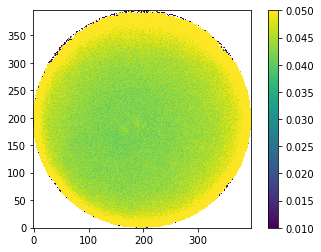

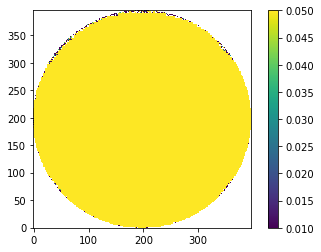

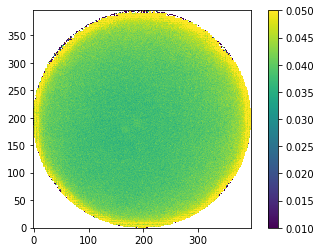

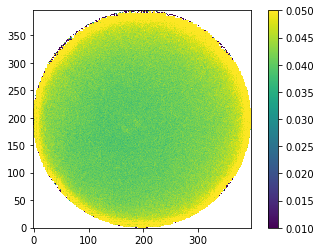

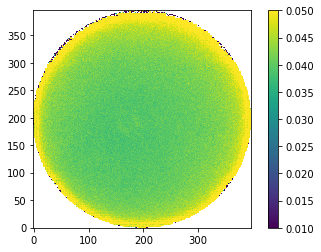

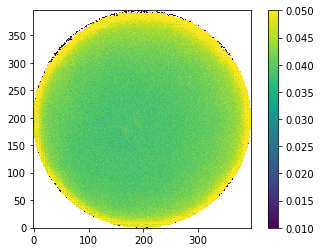

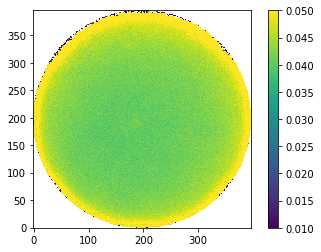

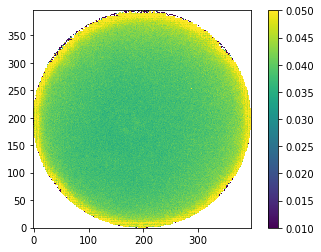

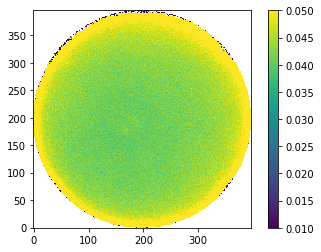

In [64]:
for i in range(12):
    plt.imshow((stdes[i].T).values/(es[i].T).values, origin='lower', vmin=0.01, vmax=0.05)
    plt.colorbar()
    plt.show()

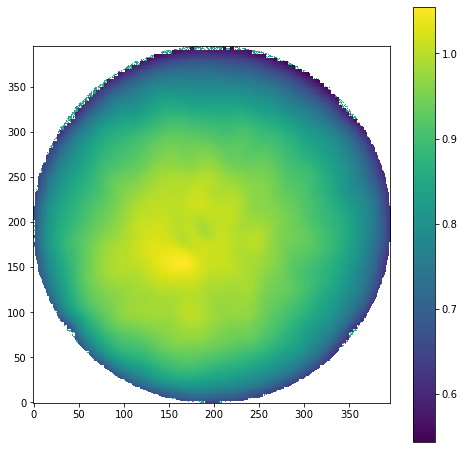

In [65]:
plt.figure(figsize=(8, 8))
plt.imshow(e0s.T, origin='lower')
plt.colorbar()

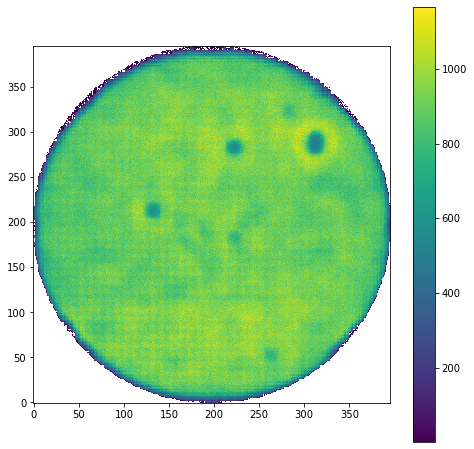

In [66]:
plt.figure(figsize=(8, 8))
plt.imshow(nevs.T, origin='lower')
plt.colorbar()

# plot  e (sum of pmts) moving average

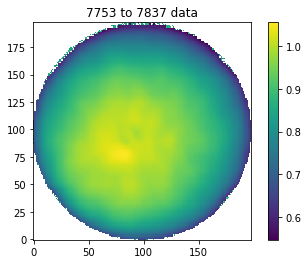

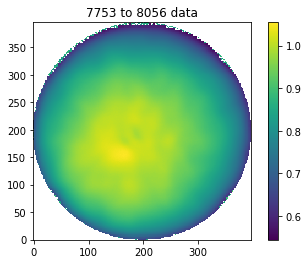

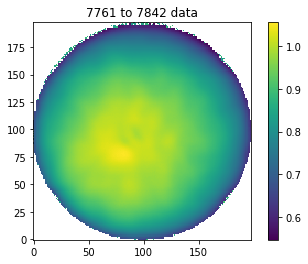

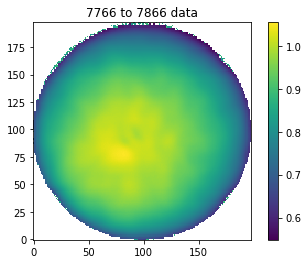

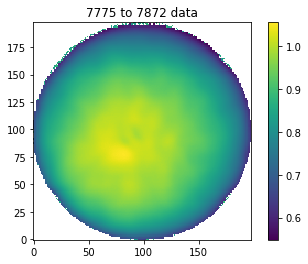

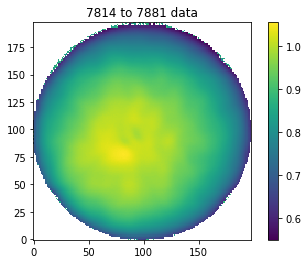

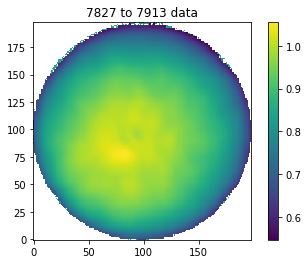

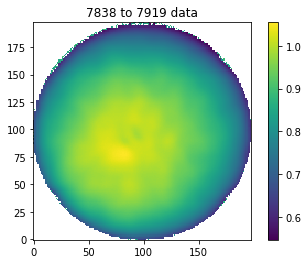

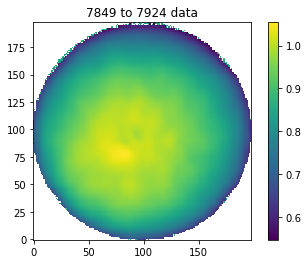

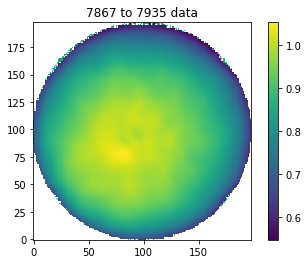

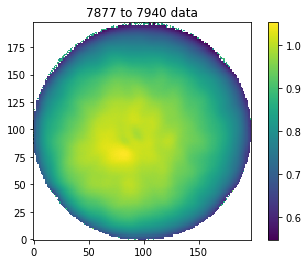

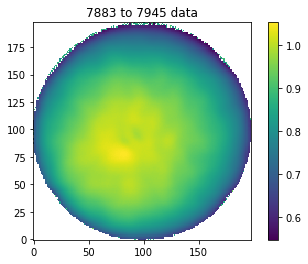

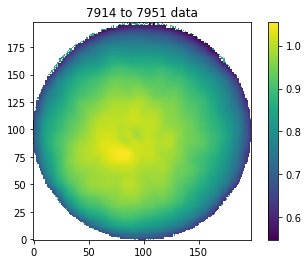

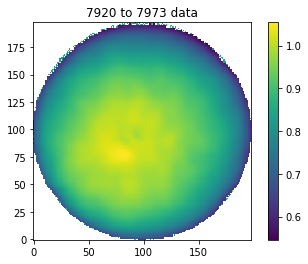

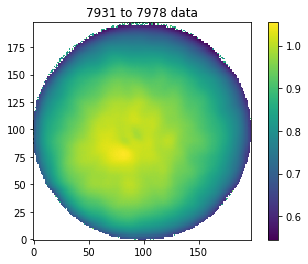

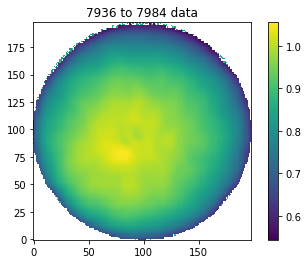

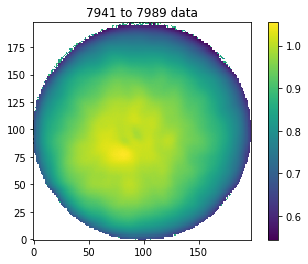

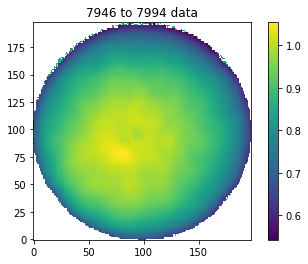

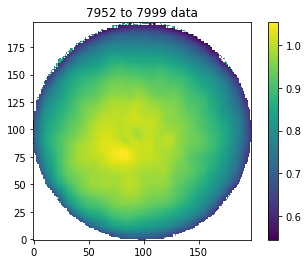

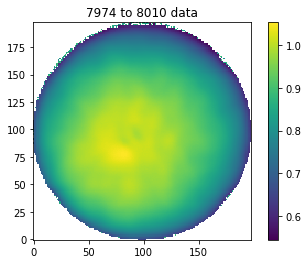

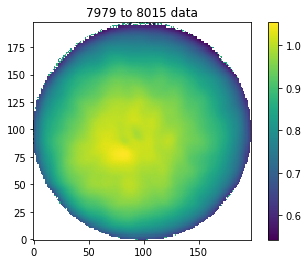

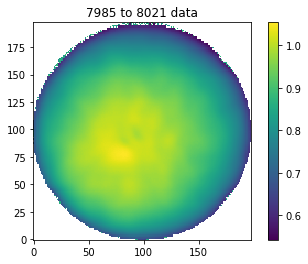

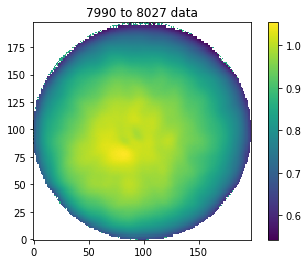

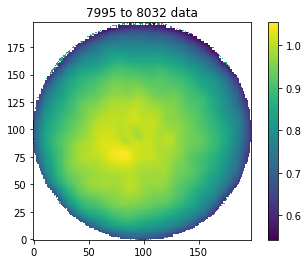

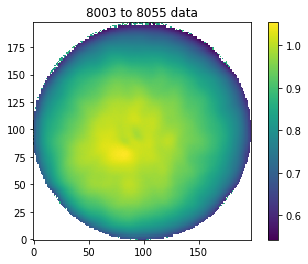

In [67]:
for f in files:
    r1, r2 = re.findall('\d+', f)[:2]
    lt = load_dst(f, 'LT', 'LightTable')
    e0s = pd.pivot_table(lt[['xbin', 'ybin','e_tot']], index = 'xbin', columns='ybin')
    plt.imshow(e0s.T, origin='lower')
    plt.colorbar()
    plt.title(f'{r1} to {r2} data')
    plt.show()

## save map in format of detsim lifetable

In [68]:
#load detsim lighttable 
new_lt = load_dst('/home/gdiaz/data_for_marija/LightTables/NEW_S2_LT.h5', 'LT', 'LightTable')
new_config = load_dst('/home/gdiaz/data_for_marija/LightTables/NEW_S2_LT.h5', 'LT', 'Config')

In [69]:
new_lt.columns

Index(['x', 'y', 'PmtR11410_0', 'PmtR11410_1', 'PmtR11410_2', 'PmtR11410_3',
       'PmtR11410_4', 'PmtR11410_5', 'PmtR11410_6', 'PmtR11410_7',
       'PmtR11410_8', 'PmtR11410_9', 'PmtR11410_10', 'PmtR11410_11',
       'PmtR11410_total'],
      dtype='object')

In [71]:
ecols = [f'e_{i}' for i in range(12)]
new_lt_data = lt_7753_8056[['xbin', 'ybin', *ecols, 'e_tot']]

In [72]:
new_lt_data.columns=new_lt.columns

In [73]:
new_lt_data.head()

,x,y,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-19.5,-19.5,0.094406,0.119418,0.094855,0.061656,0.100651,0.081245,0.072900,0.073044,0.085289,0.073245,0.085438,0.070335,1.012481
1,-19.5,-18.5,0.094367,0.119071,0.094927,0.061616,0.100668,0.081096,0.072793,0.072970,0.084934,0.073096,0.085250,0.070188,1.010974
2,-19.5,-17.5,0.094446,0.119032,0.094729,0.061592,0.100485,0.081203,0.072724,0.072966,0.084803,0.072907,0.085351,0.070188,1.010425
3,-19.5,-16.5,0.094202,0.118997,0.094733,0.061315,0.100580,0.081128,0.072682,0.072874,0.084817,0.072980,0.085203,0.070165,1.009676
4,-19.5,-15.5,0.094308,0.118824,0.094615,0.061530,0.100397,0.080921,0.072649,0.072920,0.084969,0.072989,0.085322,0.070283,1.009725


In [76]:
EL_gain = 993 #in nexus
EL_gap = 0.6
num_ielect = 1855
arbitrary_max_scale = 13000
factor = arbitrary_max_scale/(EL_gap*EL_gap)/num_ielect/new_lt_data.PmtR11410_total.max() #max scalled to 'match' data

In [77]:
new_lt_data[['PmtR11410_0', 'PmtR11410_1', 'PmtR11410_2', 'PmtR11410_3',
       'PmtR11410_4', 'PmtR11410_5', 'PmtR11410_6', 'PmtR11410_7',
       'PmtR11410_8', 'PmtR11410_9', 'PmtR11410_10', 'PmtR11410_11',
       'PmtR11410_total']] *= factor

/home/mmkekic/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [78]:
# Dont forget to change pitch in config (basically i use the same but change pitch)
new_config.loc[new_config['parameter']=='pitch_x', 'value']='1'
new_config.loc[new_config['parameter']=='pitch_y', 'value']='1'

In [79]:
with tb.open_file('/home/mmkekic/energy_resolution_study/kr_data/light_tables/S2_NEW_data.h5', 'w') as h5out:
    df_writer(h5out, new_lt_data, 'LT', 'LightTable')
    df_writer(h5out, new_config, 'LT', 'Config')
    

/home/mmkekic/IC/invisible_cities/io/dst_io.py:65: UserWarning: dataframe contains strings longer than allowed
  warnings.warn('dataframe contains strings longer than allowed', UserWarning)
